# A Quantum-Enhanced LSTM Layer

One field that so far has been poorly explored in Quantum Machine Learning is Natural Language Processing (NLP), the sub-field of Artificial Intelligence that gives computers the ability to read, write and to some extent comprehend written text. 

As documents are usually presented as sequences of words, historically one of the most successful techniques to manipulate this kind of data has been the Recurrent Neural Network architecture, and in particular a variant called Long Short-Term Memory (LSTM). LSTMs allowed machines to perform translations, classification and intent detection with state-of-the-art accuracy until the advent of Transformer networks. Still, it’s interesting at least from an educational point of view to dig into LSTMs to see what good quantum computing may bring to the field. For a more thorough discussion, please refer to “Quantum Long Short-Term Memory” by Chen, Yoo and Fang (arXiv:2009.01783) and “Recurrent Quantum Neural Networks” by J. Bausch (arXiv:2006.14619).

In [1]:
# !pip install -r requirements.txt

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qlstm_pennylane import QLSTM

c:\Users\cpb5867\Anaconda3\envs\QLSTM\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Here we define the possible tags: determinant, noun, verb.

In [3]:
tag_to_ix = {"<RX_1>": 0, "<RX_2>": 1, "<RX_3>": 2, "<RX_4>": 3, "<RX_5>": 4, "<RX_6>": 5, "<RX_7>": 6, "<RX_8>": 7, "<RX_9>": 8, "<RX_10>": 9 }  # Assign each tag with a unique index
ix_to_tag = {i:k for k,i in tag_to_ix.items()}

The function below tokenizes the sentence and matches the label to each word.

In [4]:
def prepare_sequence(seq, to_ix):
    # idxs = [to_ix[w] for w in seq]
    idxs = [to_ix[seq]]
    return torch.tensor(idxs, dtype=torch.long)

In [5]:
reaction_types = []
smiles = open('USPTO-50K/src-train.txt', 'r')
content = smiles.read()
reactions = content.split('\n')
reactions.remove('')
# chunks2 = content.split('\n')
# chunks2.remove('')
content_src_train = smiles.read()
for idx in range(len(reactions)):
    reaction_types.append(reactions[idx].replace(" ", "").split('>',1)[0] + '>')
    reactions[idx] = reactions[idx].replace(" ", "").split('>',1)[1]
    # chunks2[idx] = chunks2[idx].replace(" ", "")
    # tmp1 = chunks[idx].replace(" ", "").split('>',1)[0].replace("<RX_","")
    # print(chunks[idx] == tmp1)
    # smiles.close()
    # quit()
    # if(chunks2[idx].split('>',1)[0].replace("<RX_","") == "1"):
    #     # print(idx)
    #     idx_src_train_arr.append(idx)
smiles.close()
# smiles = open('USPTO-50K/tgt-train.txt', 'r')
# content = smiles.read()
# chunks = content.split('\n')
# chunks.remove('')
# for idx in range(len(chunks)):
#     chunks[idx] = chunks[idx].replace(" ", "")
# smiles.close()

Now we can prepare the input dataset.

In [6]:
# training_data = [
#     # Tags are: DET - determiner; NN - noun; V - verb
#     # For example, the word "The" is a determiner
#     ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
#     ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
# ]
training_data = list(zip(reactions, reaction_types))

training_data = training_data[-10:]

word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    if sent not in word_to_ix:  # word has not been assigned an index yet
        word_to_ix[sent] = len(word_to_ix)  # Assign each word with a unique index

# print(f"Vocabulary: {word_to_ix}")
# print(f"Entities: {ix_to_tag}")

The idea is to pass the two sequences through the LSTM, which will output the hidden array of vectors [h_0, h_1, h_2, h_3, h_4], one for each word. A dense layer “head” is attached to the LSTM’s outputs to calculate the probability that each word may be a determinant, noun or verb.

In [7]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, n_qubits=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        if n_qubits > 0:
            print("Tagger will use Quantum LSTM")
            self.lstm = QLSTM(embedding_dim, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        # print(sentence)
        embeds = self.word_embeddings(sentence)
        # lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        lstm_out, _ = self.lstm(embeds.view(1, 1, -1))
        # tag_logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_logits = self.hidden2tag(lstm_out.view(1, -1))
        tag_scores = F.log_softmax(tag_logits, dim=1)
        return tag_scores

In [8]:
embedding_dim = 8
hidden_dim = 6
n_epochs = 300

In [9]:
model_classical = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=0)

Tagger will use Classical LSTM


## Training

Following the example from the PyTorch website, we train the two networks (classical and quantum LSTM) for 300 epochs. 

In [10]:
def train(model, n_epochs):
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    history = {
        'loss': [],
        'acc': []
    }
    for epoch in range(n_epochs):
        losses = []
        preds = []
        targets = []
        for sentence, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_ix)
            labels = prepare_sequence(tags, tag_to_ix)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            # print("Scores")
            # print(tag_scores)
            # print("Labels")
            # print(labels)
            
            loss = loss_function(tag_scores, labels)
            loss.backward()
            optimizer.step()
            losses.append(float(loss))
            
            probs = torch.softmax(tag_scores, dim=-1)
            preds.append(probs.argmax(dim=-1))
            targets.append(labels)

        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        corrects = (preds == targets)
        accuracy = corrects.sum().float() / float(targets.size(0) )
        history['acc'].append(accuracy)

        print(f"Epoch {epoch+1} / {n_epochs}: Loss = {avg_loss:.3f} Acc = {accuracy:.2f}")

    return history

In [11]:
history_classical = train(model_classical, n_epochs)

Epoch 1 / 300: Loss = 2.397 Acc = 0.10
Epoch 2 / 300: Loss = 2.180 Acc = 0.20
Epoch 3 / 300: Loss = 2.015 Acc = 0.50
Epoch 4 / 300: Loss = 1.894 Acc = 0.50
Epoch 5 / 300: Loss = 1.809 Acc = 0.50
Epoch 6 / 300: Loss = 1.747 Acc = 0.50
Epoch 7 / 300: Loss = 1.700 Acc = 0.50
Epoch 8 / 300: Loss = 1.661 Acc = 0.50
Epoch 9 / 300: Loss = 1.627 Acc = 0.50
Epoch 10 / 300: Loss = 1.594 Acc = 0.50
Epoch 11 / 300: Loss = 1.560 Acc = 0.50
Epoch 12 / 300: Loss = 1.526 Acc = 0.50
Epoch 13 / 300: Loss = 1.491 Acc = 0.50
Epoch 14 / 300: Loss = 1.453 Acc = 0.50
Epoch 15 / 300: Loss = 1.414 Acc = 0.50
Epoch 16 / 300: Loss = 1.372 Acc = 0.50
Epoch 17 / 300: Loss = 1.329 Acc = 0.50
Epoch 18 / 300: Loss = 1.284 Acc = 0.50
Epoch 19 / 300: Loss = 1.239 Acc = 0.50
Epoch 20 / 300: Loss = 1.193 Acc = 0.60
Epoch 21 / 300: Loss = 1.149 Acc = 0.60
Epoch 22 / 300: Loss = 1.105 Acc = 0.60
Epoch 23 / 300: Loss = 1.063 Acc = 0.60
Epoch 24 / 300: Loss = 1.022 Acc = 0.60
Epoch 25 / 300: Loss = 0.983 Acc = 0.60
Epoch 26 

In [12]:
def print_result(model):
    with torch.no_grad():
        input_sentence = training_data[0][0]
        labels = training_data[0][1]
        inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(inputs)

        tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        tag_labels = [ix_to_tag[k] for k in tag_ids]
        print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")

In [13]:
print_result(model_classical)

Sentence:  Cc1c(Cl)cc(C(C)C)c2c1CC(CN)O2
Labels:    <RX_9>
Predicted: ['<RX_9>']


In [14]:
n_qubits = 4

model_quantum = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=n_qubits)

Tagger will use Quantum LSTM
weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [15]:
history_quantum = train(model_quantum, n_epochs)

Epoch 1 / 300: Loss = 2.162 Acc = 0.30
Epoch 2 / 300: Loss = 2.005 Acc = 0.50
Epoch 3 / 300: Loss = 1.889 Acc = 0.50
Epoch 4 / 300: Loss = 1.805 Acc = 0.50
Epoch 5 / 300: Loss = 1.744 Acc = 0.50
Epoch 6 / 300: Loss = 1.693 Acc = 0.50
Epoch 7 / 300: Loss = 1.646 Acc = 0.50
Epoch 8 / 300: Loss = 1.596 Acc = 0.50
Epoch 9 / 300: Loss = 1.543 Acc = 0.50
Epoch 10 / 300: Loss = 1.486 Acc = 0.50
Epoch 11 / 300: Loss = 1.428 Acc = 0.50
Epoch 12 / 300: Loss = 1.369 Acc = 0.50
Epoch 13 / 300: Loss = 1.312 Acc = 0.50
Epoch 14 / 300: Loss = 1.257 Acc = 0.50
Epoch 15 / 300: Loss = 1.208 Acc = 0.50
Epoch 16 / 300: Loss = 1.163 Acc = 0.50
Epoch 17 / 300: Loss = 1.123 Acc = 0.50
Epoch 18 / 300: Loss = 1.088 Acc = 0.60
Epoch 19 / 300: Loss = 1.057 Acc = 0.70
Epoch 20 / 300: Loss = 1.030 Acc = 0.70
Epoch 21 / 300: Loss = 1.006 Acc = 0.70
Epoch 22 / 300: Loss = 0.984 Acc = 0.70
Epoch 23 / 300: Loss = 0.965 Acc = 0.70
Epoch 24 / 300: Loss = 0.947 Acc = 0.70
Epoch 25 / 300: Loss = 0.930 Acc = 0.60
Epoch 26 

In [16]:
print_result(model_quantum)

Sentence:  Cc1c(Cl)cc(C(C)C)c2c1CC(CN)O2
Labels:    <RX_9>
Predicted: ['<RX_9>']


### Plot the training history

In [17]:
from matplotlib import pyplot as plt

def plot_history(history_classical, history_quantum):
    loss_c = history_classical['loss']
    acc_c = history_classical['acc']
    loss_q = history_quantum['loss']
    acc_q = history_quantum['acc']
    n_epochs = max([len(loss_c), len(loss_q)])
    x_epochs = [i for i in range(n_epochs)]
    
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(loss_c, label="Classical LSTM loss", color='orange', linestyle='dashed')
    ax1.plot(loss_q, label="Quantum LSTM loss", color='red', linestyle='solid')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    ax2.plot(acc_c, label="Classical LSTM accuracy", color='steelblue', linestyle='dashed')
    ax2.plot(acc_q, label="Quantum LSTM accuracy", color='blue', linestyle='solid')

    plt.title("Part-of-Speech Tagger Training")
    plt.ylim(0., 1.1)
    #plt.legend(loc="upper right")
    fig.legend(loc="upper right", bbox_to_anchor=(1,0.8), bbox_transform=ax1.transAxes)

    plt.savefig("pos_training.pdf")
    plt.savefig("pos_training.png")
    plt.show()

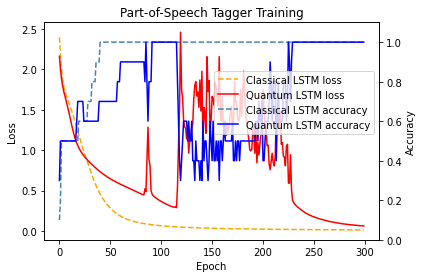

In [18]:
plot_history(history_classical, history_quantum)

The loss function decreases as a function of the training epoch, and after 300 epochs both networks are able to tag correctly the first sentence. Due to the complexity of the simulation of the quantum circuit, it took approximatively 15 minutes to finish the training, to be compared to a mere 8 seconds for the classical case. 